In [1]:
from __future__ import division, print_function, absolute_import
import logging
import time
import tensorflow as tf
import os
tf.logging.set_verbosity(tf.logging.ERROR)
import numpy as np
from config import pathDict
from conv_net.train import Train
from conv_net.test import Test
from data_transformation.data_prep import get_intersecting_images_pin, dumpStratifiedBatches_balanced_class
from plot import Plot
import pandas as pd
import seaborn as sns
%matplotlib inline
sns.set_style("whitegrid")


which_net = 'resnet'
batch_prepare = False
train = True
test = True

INPUT the RUN NAME: Options : ("A new run name" or "Any Previous Run Name"
 WHICH_RUN = sam_new
INPUT: Image-type OPTIONS: (assessor, assessor_code, aerial, overlayed, aerial_cropped, streetside and ensemble 
 IMAGE_TYPE = aerial_cropped


In [2]:
# from clean_directories import clean
# clean(dict(overlayed='summary,batch'),which_vendor='google', which_model='resnet')

## PREPARE/DUMP BATCHES:

In [4]:
start_time = time.time()

if batch_prepare:
    start_time = time.time()
    
    cmn_land_pins, cmn_house_pins = get_intersecting_images_pin(is_assessor=False, is_aerial=True,
                                                                is_streetside=False, is_overlayed=True,
                                                                is_aerial_cropped=True, is_training=True)
    print(len(cmn_land_pins), len(cmn_house_pins))
    
    tr_batch_size = 128
    ts_batch_size = (len(cmn_land_pins) + len(cmn_house_pins)) // 10
    cv_batch_size = (len(cmn_land_pins) + len(cmn_house_pins)) // 10
    
    dumpStratifiedBatches_balanced_class(cmn_land_pins, cmn_house_pins, ts_batch_size=ts_batch_size,
                                         cv_batch_size=cv_batch_size, tr_batch_size=tr_batch_size,
                                         image_type='aerial_cropped', 
                                         img_in_shape=[400, 400, 3],
                                         img_out_shape=[224, 224, 3],
                                         img_crop_shape=[128, 128, 3], 
                                         img_resize_shape=[128, 128, 3],
                                         shuffle_seed=873, get_stats=True, max_batches=None, is_training=True)

print ('--------------- %s seconds ------------------'%(time.time() - start_time))


5733 5733
--------------- 63.239805936813354 seconds ------------------


# EVALUATE MODELS:
------------

# TRAIN MODEL: Aerial Cropped
------------

## Train  learning_rate = 0.0001
-----------

In [ ]:
max_batches = 70
start_time = time.time()
if train:
    tr_obj = Train(dict(pprocessor_inp_img_shape=[224,224,3],
                        pprocessor_inp_crop_shape=[],
                        model_inp_img_shape=[224,224,3],
                        learning_rate=0.0005,
                        use_checkpoint=True,
                        save_checkpoint=True,
                        write_tensorboard_summary=False
                        ),
              device_type='gpu',
              which_net='resnet')
    (tr_loss_arr, tr_acc_arr, tr_precision_arr, tr_recall_arr, 
     cv_loss_arr, cv_acc_arr, cv_precision_arr, cv_recall_arr,
     l_rate_arr)  = tr_obj.run(num_epochs=10, num_batches=max_batches, get_stats_at=10)# + 1)
    
print('----------%s seconds------------'%(str(time.time() - start_time)))

Dumping Checkpoints to %s /Users/sam/All-Program/App-DataSet/HouseClassification/checkpoints/sam_new/aerial_cropped/resnet
Learning Rate: Initial:  0.0005
Checkpoint latest at:  /Users/sam/All-Program/App-DataSet/HouseClassification/checkpoints/sam_new/aerial_cropped/resnet/resnet_epoch_0_batch_9


In [4]:
print ('Mean Values: train_loss = %s, train_acc = %s, train_precision = %s, train_recall = %s, cv_loss = %s, cv_acc = %s, cv_precision = %s, cv_recall = %s'%(
    np.mean(tr_loss_arr), np.mean(tr_acc_arr), np.mean(tr_precision_arr), np.mean(tr_recall_arr), np.mean(cv_loss_arr), np.mean(cv_acc_arr), np.mean(cv_precision_arr), np.mean(cv_recall_arr)))

Mean Values: train_loss = 2.54335, train_acc = 0.901456, train_precision = 0.907036960152, train_recall = 0.901633522727, cv_loss = 2.57238, cv_acc = 0.836346, cv_precision = 0.831757724063, cv_recall = 0.857195474875


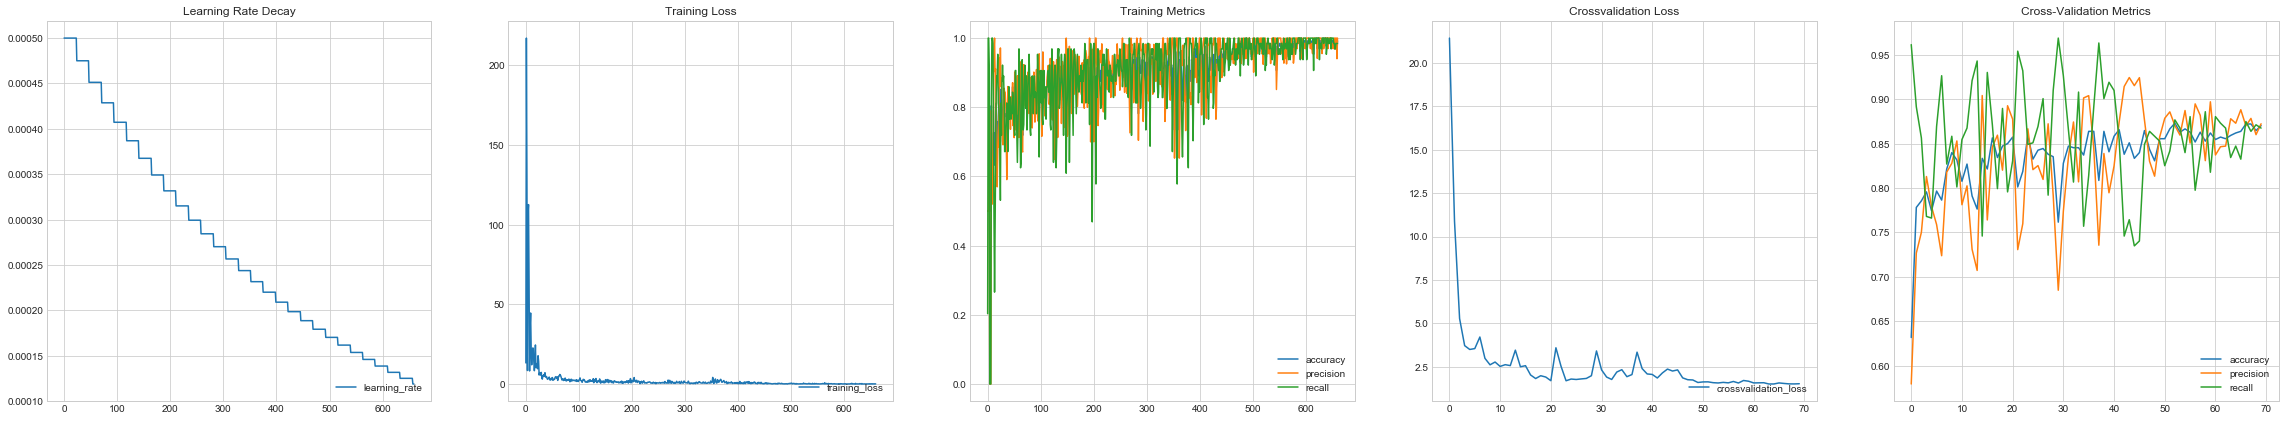

In [5]:
oj = Plot(rows=1, columns=5, fig_size=(40,7))

l_rate_df = pd.DataFrame(l_rate_arr, columns=['learning_rate'])
oj.vizualize(data=l_rate_df, colX=None, colY=None, label_col=None, viz_type='line', params={'title':'Learning Rate Decay'})

tr_loss_df = pd.DataFrame(tr_loss_arr, columns=['training_loss'])
oj.vizualize(data=tr_loss_df, colX=None, colY=None, label_col=None, viz_type='line', params={'title':'Training Loss'})
tr_data = pd.DataFrame(np.column_stack((tr_acc_arr, tr_precision_arr, tr_recall_arr)), columns=['accuracy', 'precision', 'recall'])
oj.vizualize(data=tr_data, colX=None, colY=None, label_col=None, viz_type='line', params={'title':'Training Metrics'})

cv_loss_df = pd.DataFrame(cv_loss_arr, columns=['crossvalidation_loss'])
oj.vizualize(data=cv_loss_df, colX=None, colY=None, label_col=None, viz_type='line', params={'title':'Crossvalidation Loss'})
cv_data = pd.DataFrame(np.column_stack((cv_acc_arr, cv_precision_arr, cv_recall_arr)), columns=['accuracy', 'precision', 'recall'])
oj.vizualize(data=cv_data, colX=None, colY=None, label_col=None, viz_type='line', params={'title':'Cross-Validation Metrics'})

### Cross Validation and Test : learning_rate = 0.0001

In [5]:
which_data = 'cvalid'
if test:
    tsoj = Test(params=dict(inp_img_shape=[400,400,3],
                     crop_shape=[96, 96, 3],
                     out_img_shape=[224, 224, 3]),
         which_net=which_net,
         image_type=image_type)
    cv_loss_arr, cv_acc_arr, cv_precision_arr, cv_recall_arr = tsoj.run(which_data=which_data, dump_stats=True)

Dumping Checkpoints to %s /Users/sam/All-Program/App-DataSet/HouseClassification/data_models/aerial_images/google/checkpoint/resnet
Dumping Tensorboard Summary to %s /Users/sam/All-Program/App-DataSet/HouseClassification/data_models/aerial_images/google/summary/resnet
Test Graphs: RESNET
Learning Rate: Initial:  0.0001
Test Graphs: RESNET
Learning Rate: Initial:  0.0001
Test Graphs: RESNET
Learning Rate: Initial:  0.0001
Test Graphs: RESNET
Learning Rate: Initial:  0.0001
Test Graphs: RESNET
Learning Rate: Initial:  0.0001
Test Graphs: RESNET
Learning Rate: Initial:  0.0001
Test Graphs: RESNET
Learning Rate: Initial:  0.0001
Test Graphs: RESNET
Learning Rate: Initial:  0.0001
Test Graphs: RESNET
Learning Rate: Initial:  0.0001
Test Graphs: RESNET
Learning Rate: Initial:  0.0001


In [7]:
which_data = 'test'
if test:
    tsoj = Test(params=dict(inp_img_shape=[400,400,3],
                     crop_shape=[96, 96, 3],
                     out_img_shape=[224, 224, 3]),
         which_net=which_net,
         image_type=image_type)
    ts_loss_arr, ts_acc_arr, ts_precision_arr, ts_recall_arr = tsoj.run(which_data=which_data, dump_stats=True)

Dumping Checkpoints to %s /Users/sam/All-Program/App-DataSet/HouseClassification/data_models/aerial_images/google/checkpoint/resnet
Dumping Tensorboard Summary to %s /Users/sam/All-Program/App-DataSet/HouseClassification/data_models/aerial_images/google/summary/resnet
Test Graphs: RESNET
Learning Rate: Initial:  0.0001
Test Graphs: RESNET
Learning Rate: Initial:  0.0001
Test Graphs: RESNET
Learning Rate: Initial:  0.0001
Test Graphs: RESNET
Learning Rate: Initial:  0.0001
Test Graphs: RESNET
Learning Rate: Initial:  0.0001
Test Graphs: RESNET
Learning Rate: Initial:  0.0001
Test Graphs: RESNET
Learning Rate: Initial:  0.0001
Test Graphs: RESNET
Learning Rate: Initial:  0.0001
Test Graphs: RESNET
Learning Rate: Initial:  0.0001
Test Graphs: RESNET
Learning Rate: Initial:  0.0001


In [8]:
print ('Mean Values: cvalid_loss = %s, cvalid_acc = %s, cvalid_precision = %s, cvalid_recall = %s, test_loss = %s, test_acc = %s, test_precision = %s, test_recall = %s'%(
    np.mean(cv_loss_arr), np.mean(cv_acc_arr), np.mean(cv_precision_arr), np.mean(cv_recall_arr), np.mean(ts_loss_arr), np.mean(ts_acc_arr), np.mean(ts_precision_arr), np.mean(ts_recall_arr)))

Mean Values: cvalid_loss = 3.31833, cvalid_acc = 0.792634, cvalid_precision = 0.800443959014, cvalid_recall = 0.78802946593, test_loss = 3.18185, test_acc = 0.787201, test_precision = 0.785910674674, test_recall = 0.797974217311


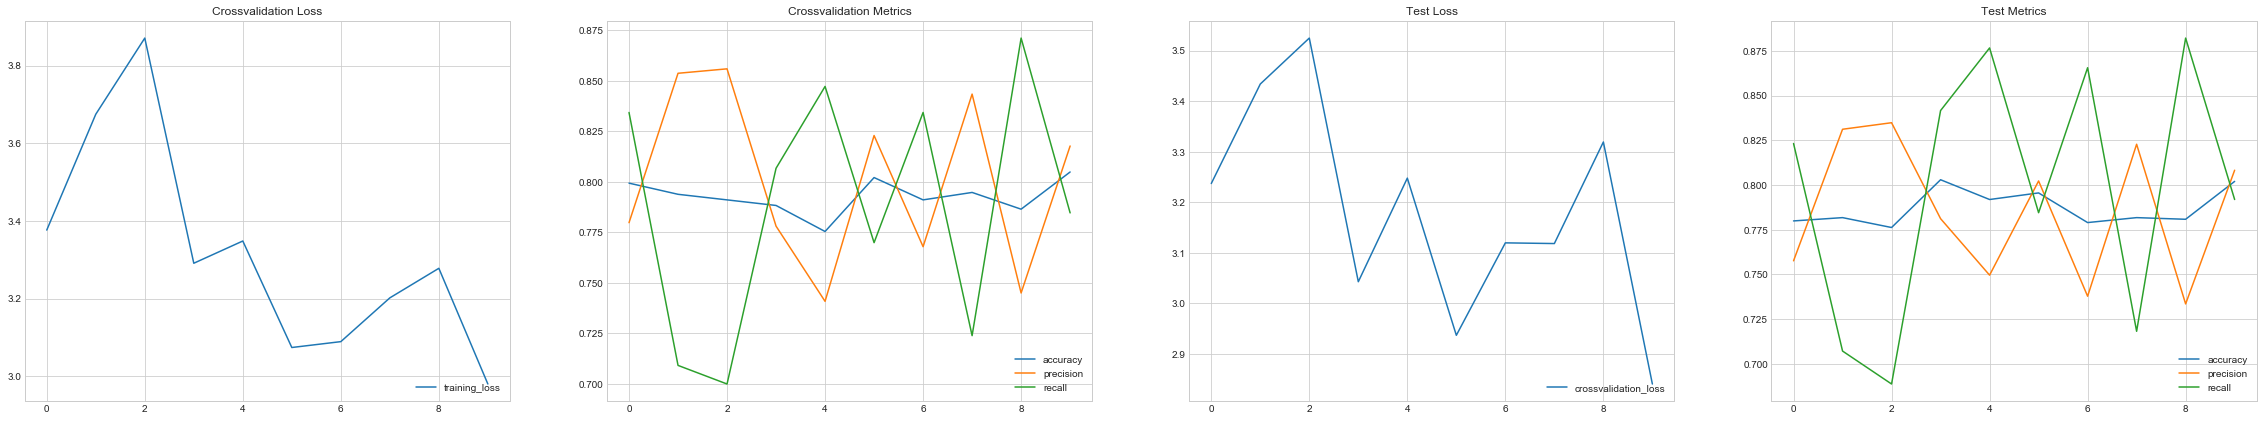

In [9]:
oj = Plot(rows=1, columns=4, fig_size=(40,7))
cv_loss_df = pd.DataFrame(cv_loss_arr, columns=['training_loss'])
oj.vizualize(data=cv_loss_df, colX=None, colY=None, label_col=None, viz_type='line', params={'title':'Crossvalidation Loss'})
cv_data = pd.DataFrame(np.column_stack((cv_acc_arr, cv_precision_arr, cv_recall_arr)), columns=['accuracy', 'precision', 'recall'])
oj.vizualize(data=cv_data, colX=None, colY=None, label_col=None, viz_type='line', params={'title':'Crossvalidation Metrics'})

ts_loss_df = pd.DataFrame(ts_loss_arr, columns=['crossvalidation_loss'])
oj.vizualize(data=ts_loss_df, colX=None, colY=None, label_col=None, viz_type='line', params={'title':'Test Loss'})
ts_data = pd.DataFrame(np.column_stack((ts_acc_arr, ts_precision_arr, ts_recall_arr)), columns=['accuracy', 'precision', 'recall'])
oj.vizualize(data=ts_data, colX=None, colY=None, label_col=None, viz_type='line', params={'title':'Test Metrics'})